In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

import xarray as xr
import intake

import config
import regrid_tools
import util

In [3]:
cat = intake.open_catalog("catalogs/fluxes-catalog-web.yml")
print(cat.yaml())

sources:
  fluxes-catalog-web:
    args:
      path: catalogs/fluxes-catalog-web.yml
    description: Flux datasets
    driver: intake.catalog.local.YAMLFileCatalog
    metadata: {}



In [4]:
version = "v2018"
yr1, yr2 = '2009', '2018'

In [5]:
ds = cat[f"fgco2_MPI_SOM_FFN_{version}"].to_dask().compute()            
ds

<xarray.Dataset>
Dimensions:         (time: 432, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2017-12-15
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables: (12/14)
    spco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spco2_smoothed  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_smoothed  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    sol             (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    kw              (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...              ...
    dco2_raw        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    dco2_smoothed   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    seamask         (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    time_bnds       (time, bnds) datetime64[ns] 1981-12-31 ... 2017-12-31
    lat_bnds        (lat, bnds) float32 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds        (lon, bnds) float32 -180.0 -179.0 -179.0 ... 179.0 180.0
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2018
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2019-03-21

In [12]:
dpm  = np.array([31., 28., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31.])
eom = np.cumsum(dpm)
bom = np.concatenate((np.array([0.]), eom[0:11]))
np.testing.assert_array_equal(eom - bom, dpm)

time = np.vstack((bom, eom)).mean(axis=0)
date = np.round(2000 * 10000 + np.arange(1,13,1) * 100. + dpm/2.)

time = xr.DataArray(
    time, dims=("time"),
    attrs={"units": "day of year", "_FillValue": None},
)    

date = xr.DataArray(
    date, dims=("time"),
    attrs={"long_name": "date", "units": "YYYYMMDD"},
)

In [17]:
with xr.set_options(keep_attrs=True):
    ds_mon = ds.sel(time=slice(yr1, yr2)).groupby("time.month").mean("time").rename({"month": "time"})
ds_mon = ds_mon[["fgco2_smoothed"]].rename({"fgco2_smoothed": "fgco2"})
ds_mon["area"] = util.compute_grid_area(ds_mon)
ds_mon["time"] = time
ds_mon.time.encoding["_FillValue"] = None
ds_mon["date"] = date
ds_mon

<xarray.Dataset>
Dimensions:  (time: 12, lat: 180, lon: 360)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    fgco2    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    area     (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    date     (time) float64 2e+07 2e+07 2e+07 2e+07 ... 2e+07 2e+07 2e+07 2e+07
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2018
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2019-03-21

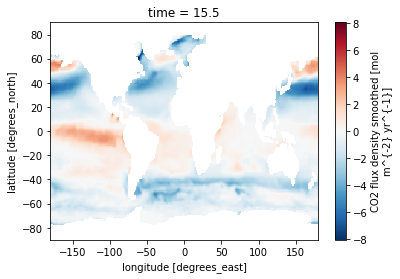

In [18]:
ds_mon.fgco2.isel(time=0).plot()

In [19]:
file_out = f"{config.flux_product_dir}/MPI-SOM-FFN.{version}.monclim_{yr1}-{yr2}.fgco2.nc"
os.environ["FILE_OUT"] = file_out
ds_mon.to_netcdf(file_out)

In [20]:
!ncdump -h ${FILE_OUT}

netcdf MPI-SOM-FFN.v2018.monclim_2009-2018.fgco2 {
dimensions:
	time = 12 ;
	lat = 180 ;
	lon = 360 ;
variables:
	double time(time) ;
		time:_FillValue = NaN ;
	float fgco2(time, lat, lon) ;
		fgco2:_FillValue = NaNf ;
		fgco2:long_name = "CO2 flux density smoothed" ;
		fgco2:standard_name = "CO2 flux density smoothed" ;
		fgco2:units = "mol m^{-2} yr^{-1}" ;
		fgco2:FillValue = 1.e+20 ;
	float lat(lat) ;
		lat:_FillValue = NaNf ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
	float lon(lon) ;
		lon:_FillValue = NaNf ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
	double area(lat, lon) ;
		area:_FillValue = NaN ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	double date(time) ;
		date:_FillValue = NaN ;
		date:long_name = "date" ;
		date:units = "YYYYMMDD" ;

// global attributes:
		